## **Google Drive Connection**

In [ ]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Paths
import os
import zipfile
import shutil

#Create the paths to deirectories
main_directory_path = "/content/drive/MyDrive/CHALLENGE 2"
models_dir = main_directory_path + "/models/"
logs_dir = main_directory_path + "/logs/"
submission_dir = main_directory_path + "/submissions/"
data_dir = main_directory_path + "/new_data/"
#backup_dir = main_directory_path + "/backup compressed/"

# Create directories if they don't exist
os.makedirs(models_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(submission_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

# Create the paths to the compresssed files
train_compressed_path_FINALE = os.path.join(data_dir, "new_train_data_compressed.npz")
test_compressed_path_FINALE = os.path.join(data_dir, "new_test_data_compressed.npz")


train_tiles_compressed_path = os.path.join(data_dir, "new_train_tiles_compressed.npz")
test_tiles_compressed_path = os.path.join(data_dir, "new_test_tiles_compressed.npz")

# Create the paths to the train labels
train_labels_path = os.path.join(data_dir, "new_train_labels.csv")
train_labels_path_FINALE = os.path.join(data_dir, "new_labels.csv")

local_train_zip = "/content/new_train_data.zip"
local_test_zip  = "/content/new_test_data.zip"

# Cartelle di estrazione locali (SSD Colab)
local_train_dir = "/content/data/new_train_data"
local_test_dir  = "/content/data/new_test_data"

os.makedirs(local_train_dir, exist_ok=True)
os.makedirs(local_test_dir, exist_ok=True)

## **Libraries Import**

In [ ]:
SEED = 42

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from scipy import stats


import hashlib
import re

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


!pip install lion-pytorch
from lion_pytorch import Lion

from datetime import datetime
data_ora_correnti = datetime.now()

data_formattata = data_ora_correnti.strftime("%Y%m%d_%H%M%S")

PyTorch version: 2.9.0+cu126
Device: cuda


## **Data Loading**

In [ ]:
# Load training and validation data as numPy vector from a compressed file (already preprocessed)
train_val = np.load(train_tiles_compressed_path)

# Separate the images from the masks in the training and validation set
train_images = train_val["images"]
train_names = train_val["names"]
train_labels = train_val["labels"]

In [ ]:
# Print the shapes of the loaded dataset
print("Training-Validation Images Shape:", train_images.shape)
print("Training-Validation Label Shape:", train_labels.shape)

Training-Validation Images Shape: (3371, 224, 224, 3)
Training-Validation Label Shape: (3371,)


In [ ]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(train_labels, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
1    1208
2     895
0     881
3     387
Name: count, dtype: int64


In [ ]:
# Define the input shape based on the training data
input_shape = (3, 224, 224)

# Define the number of classes based on the categorical labels
num_classes = 4

# Define the batch size
BATCH_SIZE = 16

#  **Data Preprocessing**

In [ ]:
import numpy as np

def extract_image_ids(names):
    ids = []
    for n in names:
        base = n.split("_t")[0]
        num  = int(base.replace("img_", ""))
        ids.append(num)
    return np.array(ids)

image_ids = extract_image_ids(train_names)

In [ ]:
# @title Augmentation cell

train_augmentation = None
val_preprocessing = None

In [ ]:
# @title Image-level train and validation split

# 1) LOAD NPZ WITH TILES

import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import mode


# 2) EXTRACT IMAGE IDS FROM TILE NAMES

def extract_image_ids(names):
    ids = []
    for n in names:
        base = n.split("_t")[0]
        num  = int(base.replace("img_", ""))
        ids.append(num)
    return np.array(ids)

image_ids = extract_image_ids(train_names)
print("Unique images:", len(np.unique(image_ids)))



# 3) RECONSTRUCT ORIGINAL LABEL FOR EACH IMAGE (MAJORITY VOTE)

unique_ids = np.unique(image_ids)
image_level_labels = {}

for img_id in unique_ids:
    mask = (image_ids == img_id)
    modal_class = int(mode(train_labels[mask], keepdims=True)[0][0])
    image_level_labels[img_id] = modal_class

# Convert to aligned arrays for stratification
img_ids_array = np.array(list(image_level_labels.keys()))
img_cls_array = np.array(list(image_level_labels.values()))

print("Image-level classes distribution:", np.bincount(img_cls_array))



# 4) TRAIN/VAL SPLIT — STRATIFIED ON IMAGE LEVEL

train_ids, val_ids = train_test_split(
    img_ids_array,
    test_size=0.1,
    random_state=42,
    stratify=img_cls_array
)

print("Train images:", len(train_ids))
print("Val images:", len(val_ids))



# 5) BUILD TILE MASKS FOR FINAL SPLIT — NO LEAKAGE

train_preind = np.isin(image_ids, train_ids)
val_preind   = np.isin(image_ids, val_ids)

train_indices = np.where(train_preind)[0]
val_indices   = np.where(val_preind)[0]



Unique images: 581
Image-level classes distribution: [158 204 150  69]
Train images: 522
Val images: 59


To prevent tiles from the same image from appearing in both the training and validation sets—which would result in **data leakage**—the train–validation split must be performed at the image level. Accordingly, we store the indices of the tiles associated with each image assigned to the training and validationation sets.

In [ ]:
# @title Dataset and transformations performing

class IndexedDataset(torch.utils.data.Dataset):

    def __init__(self, tiles, labels, indices, transform=None):
        self.tiles = tiles
        self.labels = labels
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]

        image = self.tiles[idx]
        label = self.labels[idx]

        # to tensor (come nel tuo dataset originale)
        image_tensor = torch.from_numpy(image).permute(2,0,1).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, torch.tensor(label, dtype=torch.long)


Function to perform image transformations at the batch level, preventing RAM saturation.

In [ ]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [ ]:
train_ds = IndexedDataset(
    train_images, train_labels,
    indices=train_indices,
    transform=train_augmentation
)

val_ds = IndexedDataset(
    train_images, train_labels,
    indices=val_indices,
    transform=val_preprocessing
)

In [ ]:
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break

Features batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


In [ ]:
for x, y in train_loader:
    print(x.shape)
    break

torch.Size([16, 3, 224, 224])


# **Network Parameters**

In a configuration with a network trained from scratch, it is crucial to maintain a structure that aligns with the available data. In our case, a **shallower network** reflects the limitation of having a relatively small dataset.

In [ ]:
experiment_name = "ResNetFromScratch" + '_' + data_formattata

In [ ]:
# Number of training epochs
LEARNING_RATE = 2e-5
EPOCHS = 200
PATIENCE = 20

# Regularisation
DROPOUT_RATE = 0.5       # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0         # L2 penalty

# Set up loss function and optimizer
class_counts = np.bincount(train_labels.squeeze().astype(int))
class_weights = class_counts.sum() / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss()

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rare:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("L1 Penalty:", L1_LAMBDA)
print("L2 Penalty:", L2_LAMBDA)

Epochs: 200
Batch Size: 16
Learning Rare: 2e-05
Dropout Rate: 0.5
L1 Penalty: 0
L2 Penalty: 0


# **Model**

In [ ]:
# CNN Architecture parameters

# Number of stack
STACK = 2

# Number of blocks per stack
NUM_BLOCKS = 3

# Number of channels in first block
FILTERS = 32

# Size of the filters
KERNEL_SIZE = 3


In [ ]:
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """Standard Residual Block with stackable units + Final Pooling.
    """
    def __init__(self, in_channels, filters, kernel_size=3, stack=2):
        """Initialises the ResidualBlock.

        Args:
            in_channels (int): Number of input channels.
            filters (int): Number of output filters.
            kernel_size (int, optional): Size of the convolutional kernel. Defaults to 3.
            stack (int, optional): Number of residual units to stack. Defaults to 2.
        """
        super().__init__()

        self.units = nn.ModuleList()
        current_in = in_channels

        for s in range(stack):
            layers = nn.ModuleDict()

            # Standard ResNet Unit: Conv -> BN -> ReLU -> Conv -> BN -> Add -> ReLU
            layers['conv1'] = nn.Conv2d(current_in, filters, kernel_size, padding='same', bias=False)
            layers['bn1'] = nn.BatchNorm2d(filters)
            layers['conv2'] = nn.Conv2d(filters, filters, kernel_size, padding='same', bias=False)
            layers['bn2'] = nn.BatchNorm2d(filters)

            # Skip connection projection if dimensions mismatch
            if current_in != filters:
                layers['proj'] = nn.Sequential(
                    nn.Conv2d(current_in, filters, 1, padding='same', bias=False),
                    nn.BatchNorm2d(filters)
                )

            self.units.append(layers)
            current_in = filters # After first stack, input matches filters

        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after block processing.
        """
        for unit in self.units:
            residual = x

            out = unit['conv1'](x)
            out = unit['bn1'](out)
            out = F.relu(out)

            out = unit['conv2'](out)
            out = unit['bn2'](out)

            if 'proj' in unit:
                residual = unit['proj'](residual)

            out += residual
            x = F.relu(out)

        return self.pool(x)

class ResNetModel(nn.Module):
    """Complete CNN model using multiple ResidualBlocks and Global Average Pooling.

    Suitable for classification tasks with deep architectures.
    """
    def __init__(self, input_shape, output_shape, filters=32, kernel_size=3, stack=2, blocks=3):
        """Initialises the ResNetModel.

        Args:
            input_shape (tuple): Shape of the input images (C, H, W).
            output_shape (int): Number of output classes.
            filters (int, optional): Initial number of filters for the first block. Defaults to 32.
            kernel_size (int, optional): Kernel size for convolutional layers. Defaults to 3.
            stack (int, optional): Number of residual units per block. Defaults to 2.
            blocks (int, optional): Number of `ResidualBlock` instances to stack. Defaults to 3.
        """
        super().__init__()

        self.blocks_list = nn.ModuleList()
        current_channels = input_shape[0]
        current_filters = filters

        # Stack ResidualBlocks, typically doubling filters for each.
        for b in range(blocks):
            self.blocks_list.append(
                ResidualBlock(current_channels, current_filters, kernel_size, stack)
            )
            current_channels = current_filters
            current_filters *= 2

        # Global Average Pooling, Flatten, and Dense layer for classification.
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(current_channels, output_shape)

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output probabilities after Softmax activation.
        """
        for block in self.blocks_list:
            x = block(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x    # non softmax


In [ ]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [ ]:
# Instantiate CNN model and move to computing device (CPU/GPU)
cnn_model = ResNetModel(input_shape, num_classes, FILTERS, KERNEL_SIZE, STACK, NUM_BLOCKS).to(device)

# Display model architecture summary
summary(cnn_model, input_size=input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
            Conv2d-3         [-1, 32, 224, 224]           9,216
       BatchNorm2d-4         [-1, 32, 224, 224]              64
            Conv2d-5         [-1, 32, 224, 224]              96
       BatchNorm2d-6         [-1, 32, 224, 224]              64
            Conv2d-7         [-1, 32, 224, 224]           9,216
       BatchNorm2d-8         [-1, 32, 224, 224]              64
            Conv2d-9         [-1, 32, 224, 224]           9,216
      BatchNorm2d-10         [-1, 32, 224, 224]              64
        MaxPool2d-11         [-1, 32, 112, 112]               0
    ResidualBlock-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 64, 112, 112]          18,432
      BatchNorm2d-14         [-1, 64, 1

In [ ]:
# Set up TensorBoard logging and save model architecture

writer = SummaryWriter(log_dir=logs_dir)
x = torch.randn(1, input_shape[0], input_shape[1], input_shape[2]).to(device)
writer.add_graph(cnn_model, x)

# Define LION optimizer with L2 regularization
optimizer = Lion(cnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

## **Model Training**

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):

    # Set model to training mode
    model.train()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [ ]:
def validate_one_epoch(model, val_loader, criterion, device):

    # Set model to evaluation mode
    model.eval()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [ ]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):

    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [ ]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0
        # Define model_save_path here so it's available for restoring weights
        model_save_path = f"{models_dir}{experiment_name}_model.pt"

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                print(f"New best {evaluation_metric}: {best_metric:.4f} at epoch {best_epoch}")
                os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
                torch.save(model.state_dict(), model_save_path)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    history_save_path = f"{models_dir}{experiment_name}_history.pt"
    os.makedirs(os.path.dirname(history_save_path), exist_ok=True)
    torch.save(training_history, history_save_path)

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model_load_path = f"{models_dir}{experiment_name}_model.pt" # Use models_dir for loading
        model.load_state_dict(torch.load(model_load_path))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")


    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [ ]:
%%time
# Train model and track training history
cnn_model, training_history = fit(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name=experiment_name,
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = cnn_model
    best_performance = training_history['val_f1'][-1]

Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3708, F1 Score=0.3005 | Val: Loss=1.3625, F1 Score=0.1635
New best val_f1: 0.1635 at epoch 1
Epoch   2/200 | Train: Loss=1.2808, F1 Score=0.3280 | Val: Loss=1.4485, F1 Score=0.2119
New best val_f1: 0.2119 at epoch 2
Epoch   3/200 | Train: Loss=1.2600, F1 Score=0.3503 | Val: Loss=1.4058, F1 Score=0.2147
New best val_f1: 0.2147 at epoch 3
Epoch   4/200 | Train: Loss=1.2529, F1 Score=0.3725 | Val: Loss=1.3874, F1 Score=0.2721
New best val_f1: 0.2721 at epoch 4
Epoch   5/200 | Train: Loss=1.2453, F1 Score=0.3841 | Val: Loss=1.4014, F1 Score=0.2303
Epoch   6/200 | Train: Loss=1.2406, F1 Score=0.3832 | Val: Loss=1.4043, F1 Score=0.2518
Epoch   7/200 | Train: Loss=1.2340, F1 Score=0.3893 | Val: Loss=1.4111, F1 Score=0.2591
Epoch   8/200 | Train: Loss=1.2210, F1 Score=0.4028 | Val: Loss=1.4067, F1 Score=0.2817
New best val_f1: 0.2817 at epoch 8
Epoch   9/200 | Train: Loss=1.2148, F1 Score=0.4171 | Val: Loss=1.4175, F1 Score=0.2711
Epoch  10/

## **Plot History**

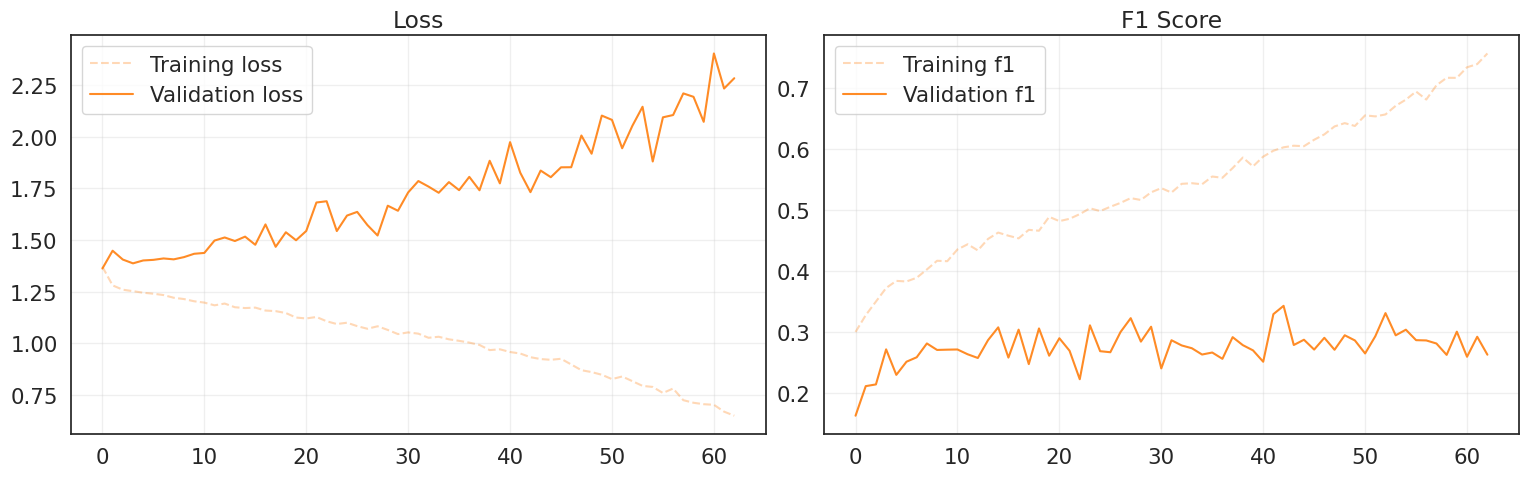

In [ ]:
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

## **Plot Confusion Matrix**

Accuracy over the validation set: 0.3528
Precision over the validation set: 0.3454
Recall over the validation set: 0.3528
F1 score over the validation set: 0.3422


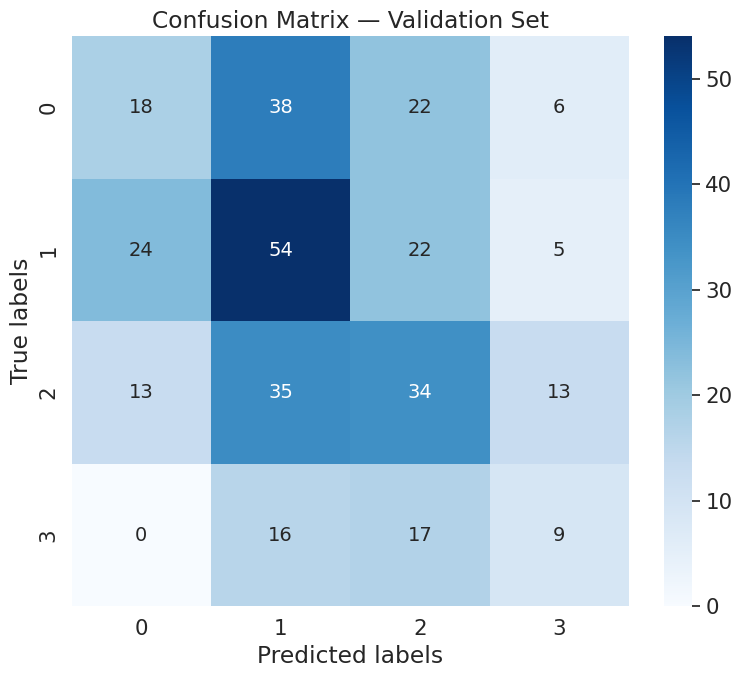

In [ ]:
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = cnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

The confusion matrix shows that the network is able to capture the overall class distribution, but struggles to distinguish among the **Luminal A**, **Luminal B**, and **HER2(+)** classes. The poorer performance observed for the **Triple Negative** class is primarily due to its minority representation in the dataset.

# **INFERENCE**

In [ ]:
# Remove training images from memory to prevent RAM saturation
import gc

del train_images
gc.collect()
torch.cuda.empty_cache()


In [ ]:
# @title Load .npz with Tiles

# LOAD TEST DATA
test = np.load(test_tiles_compressed_path)

test_images  = test["images"]
test_names   = test["names"]
test_weights = test["weights"]

print(test_images.shape, test_weights.shape)

# Chosing to use mask-weighted soft voting or not
WEIGHTED = False

(2707, 224, 224, 3) (2707,)


In [ ]:
import torch
from torchvision import transforms


test_preprocessing = None

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]

        img_tensor = torch.from_numpy(img).permute(2, 0, 1).float()

        if self.transform:
            img_tensor = self.transform(img_tensor)
        return img_tensor, idx


In [ ]:
test_ds = TestDataset(test_images, transform=test_preprocessing)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


In [ ]:
cnn_model.eval()
test_predictions = []

with torch.no_grad():
    for imgs, idxs in test_loader:
        imgs = imgs.to(torch.float32).to(device)
        logits = cnn_model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy()
        test_predictions.append(preds)

test_predictions = np.concatenate(test_predictions)


In [ ]:
# @title Mask-weighted soft voting

from collections import defaultdict

def tile_voting_weighted(names, predictions, weights):
    groups = defaultdict(list)

    for name, pred, w in zip(names, predictions, weights):
        base = name.split("_t")[0]
        groups[base].append((pred, w))

    final_preds = {}

    for img_name, items in groups.items():
        class_scores = defaultdict(float)

        for pred, w in items:
            class_scores[pred] += w

        winner = max(class_scores, key=class_scores.get)
        final_preds[img_name] = int(winner)

    return final_preds


In [ ]:
# @title Hard voting

from collections import defaultdict
from scipy.stats import mode
import numpy as np

def tile_voting_mode(names, predictions):
    groups = defaultdict(list)

    for name, pred in zip(names, predictions):
        base = name.split("_t")[0]
        groups[base].append(pred)

    final_preds = {}

    for img_name, preds in groups.items():
        preds = np.array(preds)
        winner = mode(preds, keepdims=True)[0][0]
        final_preds[img_name] = int(winner)

    return final_preds


In [ ]:
# Performing voting

if WEIGHTED:
  print("Using weighted voting")
  final_predictions = tile_voting_weighted(
      test_names,
      test_predictions,
      test_weights
  )
else:
  print("Using mode voting")
  final_predictions = tile_voting_mode(
      test_names,
      test_predictions
  )

for img, pred in final_predictions.items():
    print(img, "→ predicted class:", pred)


Using mode voting
img_0000 → predicted class: 1
img_0001 → predicted class: 1
img_0002 → predicted class: 0
img_0003 → predicted class: 1
img_0004 → predicted class: 0
img_0005 → predicted class: 2
img_0006 → predicted class: 3
img_0007 → predicted class: 1
img_0008 → predicted class: 0
img_0009 → predicted class: 1
img_0010 → predicted class: 1
img_0011 → predicted class: 1
img_0012 → predicted class: 2
img_0013 → predicted class: 1
img_0014 → predicted class: 1
img_0015 → predicted class: 2
img_0016 → predicted class: 2
img_0017 → predicted class: 1
img_0018 → predicted class: 1
img_0019 → predicted class: 2
img_0020 → predicted class: 1
img_0021 → predicted class: 2
img_0022 → predicted class: 2
img_0023 → predicted class: 1
img_0024 → predicted class: 2
img_0025 → predicted class: 0
img_0026 → predicted class: 1
img_0027 → predicted class: 1
img_0028 → predicted class: 1
img_0029 → predicted class: 2
img_0030 → predicted class: 2
img_0031 → predicted class: 2
img_0032 → predicted c

In [ ]:
# Labels dictionary
labels = {
    0: 'Luminal A',
    1: 'Luminal B',
    2: 'HER2(+)',
    3: 'Triple negative',
}

# Convert dict → sorted list
sorted_items = sorted(final_predictions.items(), key=lambda x: x[0])

sample_index = [f"{name}.png" for name, pred in sorted_items]
pred_classes = [pred for name, pred in sorted_items]
pred_labels  = [labels[int(c)] for c in pred_classes]

submission_df = pd.DataFrame({
    "sample_index": sample_index,
    "label": pred_labels
})

display(submission_df.head())
print(submission_df["label"].value_counts())


,sample_index,label
0,img_0000.png,Luminal B
1,img_0001.png,Luminal B
2,img_0002.png,Luminal A
3,img_0003.png,Luminal B
4,img_0004.png,Luminal A


label
Luminal B          242
HER2(+)            143
Luminal A           77
Triple negative     15
Name: count, dtype: int64


In [ ]:
# Save the submission DataFrame to a CSV file with the specified format

submission_df.to_csv(submission_dir+f'submission_'+experiment_name+'.csv', index=False)
print("Submission file updated with the correct format and saved successfully!")

Submission file updated with the correct format and saved successfully!
